# 1. 환경 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings('ignore')

import shap
import scipy as sp

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

2024-04-18 16:46:12.707520: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 16:46:12.752966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 16:46:13.319887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device: cuda


# 2. 데이터셋 제작

## 2-1. 원본 데이터 불러오기

### 2-1.1 원본 데이터 가공

In [3]:
df = pd.read_csv("/home/jupyter/Korean_Text_Detoxification/data/korean_malicious_comments/Dataset.csv", sep="\t")
df.columns = ['content', 'label']
print(df.shape)
df.head()

(10000, 2)


,content,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,0.0
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,0.0
2,짱깨 꺼라ㅡ패쓰,0.0
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,1.0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,1.0


In [16]:
file_path = '/home/jupyter/Korean_Text_Detoxification/data/curse_detection/dataset.txt'
df2 = pd.read_csv(file_path, delimiter='|', header=None, names=['content', 'label'])
# df2의 label 값 0과 1 swap
df2['label'] = df2['label'].apply(lambda x: 1 if x == 0 else 0)
print(df2.shape)
df2.head()

(5824, 2)


,content,label
0,좌배 까는건 ㅇㅂ,0
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,1
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,0
3,세탁이라고 봐도 된다,1
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,0


In [17]:
merge_df = pd.concat([df, df2], ignore_index=True)
print(merge_df.shape)
merge_df.head()

(15824, 2)


,content,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,0.0
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,0.0
2,짱깨 꺼라ㅡ패쓰,0.0
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,1.0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,1.0


In [18]:
merge_df.to_csv('/home/jupyter/Korean_Text_Detoxification/data/merge_dataset.csv', index=False)

## 2-2. 데이터 전처리

In [2]:
df = pd.read_csv("/home/jupyter/Korean_Text_Detoxification/data/merge_dataset.csv", sep=",")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15824 entries, 0 to 15823
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   content  15824 non-null  object 
 1   label    15799 non-null  float64
dtypes: float64(1), object(1)
memory usage: 247.4+ KB


In [4]:
df

,content,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,0.0
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,0.0
2,짱깨 꺼라ㅡ패쓰,0.0
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,1.0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,1.0
...,...,...
15819,좌우 헬파이어 3개씩 6개 장착에 아파치보다 약하지만 20mm 기관포 장착임,1.0
15820,"세금 내놓으라고 데모질 중 ㅋㅋ간첩, 도둑놈 새끼들이 대통령 해처먹으니까 나도 같...",0.0
15821,너가 한 말 중에,1.0
15822,제갈대중 ㅇㅂ,1.0


In [5]:
null_idx = df[df.label.isnull()].index
df.loc[null_idx, "content"]

1602    응애 응애 엄마 저 맘에 안들죠? ........아들 ?? " 너 내가 우스워 보이...
1654           토니스타크 평소 "아이엠그루트"라는 유행어를 부러워했다는게 학계의 정설\t1
1992    "13일 현대차에 따르면 올 들어 국내 소비자들의 수입차 구매의향률이 3년 만에 하...
2920                 에이프릴이 한마디 합니다 "예쁜게 죄" 구하라님 "무기징역"\t1
3720          답글 글씨체를 봐라 저게 애새끼가 쓴거냐?"빨갱이새끼가 쓴거지 ㅁㅈㅎㅉㅉ\t0
3807    알겠다이기ㅋㅋ 딱 채찍쳐맞는거 좋아하는 한국식 마인드네. 노예마인드. 조금만 성공한...
3908           이래서 스스로 걸리거든 "죄인들이"~ㅎㅎㅎ 재미보고 털리고 그치~~~?\t0
4241    아버지는 내재된 악마들을 다룰 정신적 힘을 가지고 있지 않았다." 이 말한마디가 사...
4283    댓글 중 "선동 당해서 촞불든 개돼지 홍어들도 단죄를 받아야 할 공범자들이다"에10...
5000    스파이 제안받고 살해 안당하는 법1. 처음에 스파이 제안을 받았을때 "중국을 위해서...
5521    "국방부 "까지 ㅡㄱ ㅐ 엿같은 ㅈ ㅣ랄주댕이...좌빨에서 ㅡ인민군대로 ㅡ가려는건가...
5866    쌩뚱맞게 60대최반엌 치매라니 그것도 곱게 사는 사모님이- -" 알콜중독도 아니고 ...
6477    페미메퇘지쿵쾅년인 메갈페미들은 니들이 좋아하는 싫어요 ㄱㄱ제발부탁해~~"일반 여성"...
6538    아니 ㅆㅂ 그런 "카더라"가 넘쳐난다고 그거에 대해서 혹시 댓글게이는 뭔가 아는거 ...
6771    저 때 투니버스에서 코요태 짧게 인터뷰 했었는데 김종민이 "노래는 뭐 신지가 다 하...
6932               개 족 가튼 국방부의 "휴기연장콜센터"발족을 축하한다 ㅆ ㅂ..\t0
7199    민족적 자존심과 애국심을 갖고 국산품 이용합시다 . . . "겸손"한 마음으로 재산...
7252    아나운서는 

In [6]:
# label 은 content의 가장 끝 문자열로 설정
df.loc[null_idx, "label"] = df.loc[null_idx, "content"].apply(lambda x: x[-1])

# content는 "\t" 앞부분까지의 문자열로 설정
df.loc[null_idx, "content"] = df.loc[null_idx, "content"].apply(lambda x: x[:-2])

In [7]:
df = df.astype({"label":"int"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15824 entries, 0 to 15823
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  15824 non-null  object
 1   label    15824 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 247.4+ KB


## 2-3. Train set / Test set으로 나누기

In [8]:
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

In [9]:
# 데이터셋 갯수 확인
print('중복 제거 전 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 전 테스트 데이터셋 : {}'.format(len(test_data)))

# 중복 데이터 제거
train_data.drop_duplicates(subset=["content"], inplace= True)
test_data.drop_duplicates(subset=["content"], inplace= True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

중복 제거 전 학습 데이터셋 : 12659
중복 제거 전 테스트 데이터셋 : 3165
중복 제거 후 학습 데이터셋 : 11730
중복 제거 후 테스트 데이터셋 : 3108


## 2-4. 토크나이징

In [10]:
# MODEL_NAME = "beomi/KcELECTRA-base"
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [11]:
tokenized_train_sentences = tokenizer(
    list(train_data["content"]),
    return_tensors="pt",                # pytorch의 tensor 형태로 return
    max_length=128,                     # 최대 토큰길이 설정
    padding=True,                       # 제로패딩 설정
    truncation=True,                    # max_length 초과 토큰 truncate
    add_special_tokens=True,            # special token 추가
    )

In [12]:
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '김포', '##는', '뭐', '김', '네', '##장', '##씩', '싸', '##먹는', '새끼들이', '##냐', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

In [13]:
tokenized_test_sentences = tokenizer(
    list(test_data["content"]),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

## 2-5. 데이터셋 생성

In [14]:
class CurseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_label = train_data["label"].values
test_label = test_data["label"].values

train_dataset = CurseDataset(tokenized_train_sentences, train_label)
test_dataset = CurseDataset(tokenized_test_sentences, test_label)

# 3. 모델 학습

## 3-1. 모델 불러오기

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARA

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

## 3-2. 학습 파라미터 설정

In [17]:
training_args = TrainingArguments(
    output_dir='./',                    # 학습결과 저장경로
    num_train_epochs=15,                # 학습 epoch 설정
    per_device_train_batch_size=16,      # train batch_size 설정
    per_device_eval_batch_size=64,      # test batch_size 설정
    logging_dir='./logs',               # 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## 3-3. 학습

In [23]:
trainer.train()

Step,Training Loss
500,0.021500
1000,0.012200
1500,0.004300
2000,0.004700
2500,0.001600
3000,0.001100
3500,0.001200


TrainOutput(global_step=3675, training_loss=0.006422849625957255, metrics={'train_runtime': 1040.8618, 'train_samples_per_second': 169.043, 'train_steps_per_second': 3.531, 'total_flos': 1.161464287228416e+16, 'train_loss': 0.006422849625957255, 'epoch': 15.0})

# 4. 모델 평가

In [24]:
# 모델 불러오기
model.load_state_dict(torch.load('/home/jupyter/Korean_Text_Detoxification/checkpoint-4500/pytorch_model.bin'))

RuntimeError: Error(s) in loading state_dict for ElectraForSequenceClassification:
	Unexpected key(s) in state_dict: "electra.embeddings.position_ids". 

In [25]:
trainer.evaluate(eval_dataset=test_dataset)

{'eval_loss': 0.6401873230934143,
 'eval_accuracy': 0.9234234234234234,
 'eval_f1': 0.9321163719338277,
 'eval_precision': 0.9347826086956522,
 'eval_recall': 0.9294653014789533,
 'eval_runtime': 3.3824,
 'eval_samples_per_second': 918.883,
 'eval_steps_per_second': 5.026,
 'epoch': 15.0}

In [26]:
# 0: curse, 1: non_curse
def sentence_predict(sent):
    # 평가모드로 변경
    model.eval()

    # 입력된 문장 토크나이징
    tokenized_sent = tokenizer(
        sent,
        return_tensors="pt",
        truncation=True,
        add_special_tokens=True,
        max_length=128
    )
    
    # 모델이 위치한 GPU로 이동 
    tokenized_sent.to(device)

    # 예측
    with torch.no_grad():
        outputs = model(
            input_ids=tokenized_sent["input_ids"],
            attention_mask=tokenized_sent["attention_mask"],
            token_type_ids=tokenized_sent["token_type_ids"]
            )

    # 결과 return
    logits = outputs[0]
    logits = logits.detach().cpu()
    result = logits.argmax(-1)
    if result == 0:
        result = " >> 악성댓글 👿"
    elif result == 1:
        result = " >> 정상댓글 😀"
    return result
#0 입력시 종료
while True:
    sentence = input("댓글을 입력해주세요: ")
    if sentence == "0":
        break
    else:
        print(f'댓글: {sentence}')
    print(sentence_predict(sentence))
    print("\n")

댓글: 나ㅁ들 다가는 군대 참 시끄럽네요ㅜㅋㅋ
 >> 정상댓글 😀


댓글: 남들 다 가는 군대 참 시끄럽네요ㅠㅋㅋ
 >> 정상댓글 😀


댓글: 남들 모두 가는 군대 소란스럽네요ㅠㅋㅋ
 >> 정상댓글 😀


댓글: 저 분 상판떼기는 좀 치워주세요
 >> 악성댓글 👿


댓글: 저 분의 얼굴은 좀 치워주세요
 >> 악성댓글 👿


댓글: 저 분의 게시글은 삭제 부탁드립니다.
 >> 정상댓글 😀


댓글: 저 분의 불쾌한 발언은 삭제해 주세요
 >> 정상댓글 😀


댓글: 저 분의 불쾌한 발언은 제거해 주시면 감사하겠습니다.
 >> 정상댓글 😀


댓글: 북한 사람들은 아직도 70년대 스타일로 만드네ㅋㅋ
 >> 정상댓글 😀


댓글: 나이가 들어서 어떻게 아이돌 가수가 많은 곳에서 버틸 수 있겠어요?
 >> 정상댓글 😀


댓글: 나이가 들어서 어떻게 아이돌 가수가 많은 곳에서 버틸 수 있겠어요?
 >> 정상댓글 😀


댓글: 불륜을 다룬 영화. 흥..
 >> 정상댓글 😀


댓글: 참 특이한 사태가 많은 것이 문재인 정부예요... 비정상적인 것을 이해할 수 있다는 지지자들이 더 이상하지만...
 >> 정상댓글 😀


댓글: 참 특이한 사태가 많은 것이 문재인 정부야... 비정상적인 것을 이해할 수 있다는 지지자들이 더 이상하지만...
 >> 정상댓글 😀


댓글: 참 초유의 사태가 많은 것이 문재인 정부야... 비정상적인 것을 이해할 수 있다는 지지자들이 더 이상하지만...
 >> 정상댓글 😀


댓글: 참 특이한 사태가 많은 것이 문재인 정부예요... 비정상적인 것을 이해할 수 있다는 지지자들이 더 이상하지만...
 >> 정상댓글 😀


댓글: 일베를 하면서 정상인 척하는 것 정말 웃기네요. 아니면 차라리 그런 척하는 게 낫지, 진심이면 다른 곳에서 놀아보세요.
 >> 정상댓글 😀


댓글: 일베를 하면서 정상인 척하는 것 정말 웃기네요. 아니면 차라리 그런 척하는 게 낫지, 진심이면 다른 곳에서 놀아보세요.
 >> 정상댓글 😀


댓글: 이런 불쾌한 얘기를

# SHAP

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(array(['', '에스', '더 ', '정말 ', '마음이 ', '따', '듯', '하고 ', '큰 ', '사람', '같네요',
       ''], dtype=object),)


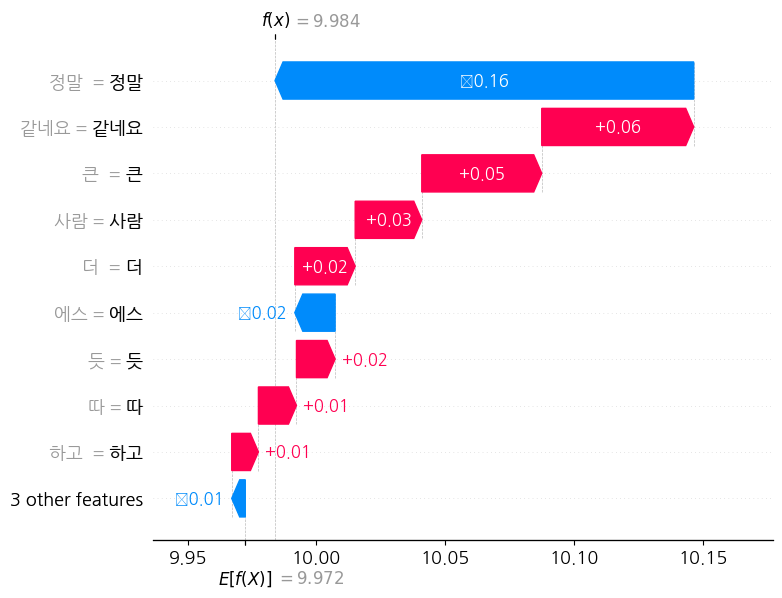

In [6]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=128) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)
# input_text = '어제 넘웃겻어여 ㅋㅋ특히 도전골든벨 ㅋㅋㅋ코요테 영원하라'
# input_text = '혐짤표시해라 ㅅㅂ 기분 더럽노'
input_text = '에스더 정말 마음이 따듯하고 큰 사람같네요'
shap_values = explainer([input_text])
print(shap_values.data)
shap.plots.waterfall(shap_values[0])
shap.initjs()
shap.plots.force(shap_values[0])

In [54]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=128) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T›
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# SHAP을 적용할 입력 데이터 선택
num_samples = 10
sample_indices = range(num_samples)
samples = [test_data.iloc[i]["content"] for i in sample_indices]
shap_values = explainer(samples)

PartitionExplainer explainer: 11it [00:12,  3.23s/it]                        


In [55]:
samples

['씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ',
 '아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도저히 이해가 안되네요 법을 바꾸기 위해 노력하세요 저런 능력으로 불법적인 일을 공공의 이익으로 포장하지 마시구요',
 '다음도 들어와라하고...다른 의견내는 유튜버 목 자르고....추아줌마 꺼 여기저기서 진술나오니...무슨 기강감찰이니 하며 협박들어가고..... 댓글에 중국 러시아 욕하는 사람들 이제 아가리 닥쳐라. 우리나라도 똑같이 되었다.',
 '지연이 얼굴은 더 배우같네...',
 '개별 공무원 뷰웅들의 헷지랄에 뭔 청와대까지 들먹이는지... 빠끄네 때도 순시리가 개뻘짓했지 청와대는 암것도 않했지 말입니다~',
 '대깨문이 문재인 협박범을 쉴드치네? 역시 대가리가 붕어인듯~',
 '돈이전부는 아니라지만 첫째가 돈이 먼저지 이세상 에는 돈으로 세상을사니ㅠ',
 '시어머니 모셔다 친정엄마 생신상도 차려줄건가! 제능력껏 하던가 친정엄마까지 모셔다 생고생시키면서 점수따고싶나 골빈건지 철딱서니가 없는건지 나이도 40 이나 먹었구만!',
 '한국와서살면 그정돈 아무것도아닐텐데....이참에 귀화해라',
 '아 이 개병신새끼씨발ㅋㅋ']

In [56]:
shap_values

.values =
array([array([-0.0006912 , -0.02056258, -0.00738998, -0.00899147, -0.02070763,
              -0.01650174, -0.01262137, -0.0272406 ,  0.00022729,  0.01073652,
               0.01114958, -0.00787449, -0.00735652,  0.02546394,  0.00584018,
               0.07309377,  0.04825014,  0.06315142, -0.04279453,  0.09432417,
              -0.16638273, -0.01280546, -0.01487118,  0.        ])            ,
       array([ 0.00048628, -0.01325956,  0.01677185, -0.03087014,  0.11836731,
              -0.01776606,  0.03170764,  0.0134694 ,  0.03915453,  0.00770688,
               0.03282768, -0.00660247,  0.04441947,  0.02368253, -0.01411718,
              -0.01203948,  0.00326617, -0.00174753, -0.00235134, -0.00068173,
              -0.00774246, -0.00866324, -0.00886802, -0.00822766, -0.00514325,
              -0.00810605, -0.03256185, -0.01758815,  0.00060222,  0.00060222,
              -0.00846432, -0.0231957 ,  0.00717807, -0.03364974, -0.08031845,
              -0.01493996, -0.02957606, -

In [50]:
samples[5]

'대깨문이 문재인 협박범을 쉴드치네? 역시 대가리가 붕어인듯~'

In [57]:
shap_values[5]

.values =
array([ 0.        , -0.33766222,  0.29422566, -0.22868499,  0.50718166,
        0.02840446,  0.05955225,  0.03414613, -0.21175283, -0.56736583,
       -0.06091577, -0.00749713, -0.41407418,  0.        ])

.base_values =
9.917678833007812

.data =
array(['', '대깨문이 ', '문재인 ', '협박', '범을 ', '쉴드치', '네', '? ', '역시 ', '대가리가 ',
       '붕어', '인듯', '~', ''], dtype='<U5')

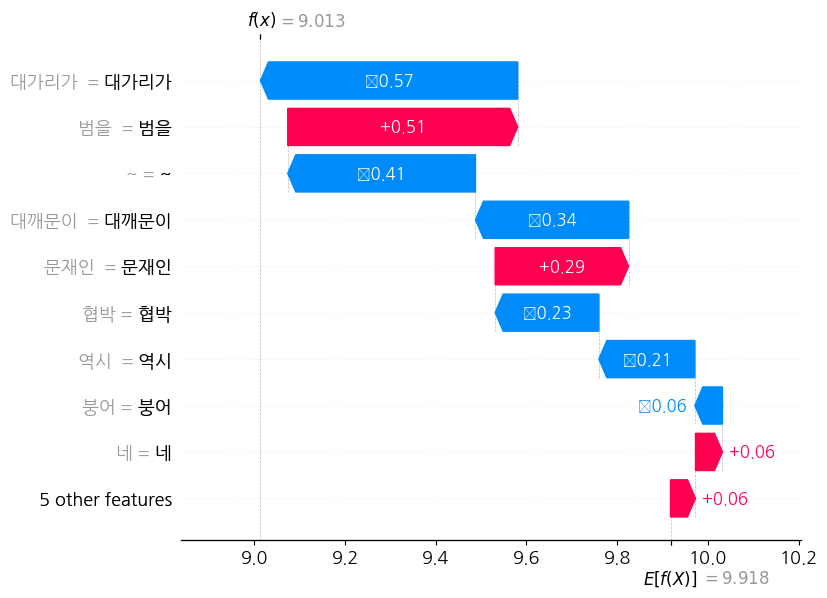

In [58]:
shap.plots.waterfall(shap_values[5])

In [32]:
# force plot을 활용한 첫 번째 예측 설명의 시각화
shap.initjs()
shap.plots.force(shap_values[5])

In [7]:
sample = ['우리나라를 얼마나 개돼지로 보는건지 짱깨랑은 상종을 하지 말아야해']
shap_values = explainer(sample)
shap_values

.values =
array([[ 1.60932541e-06,  2.20121324e-01, -6.85901910e-01,
        -2.05193558e+00, -3.37285280e-01,  2.75001824e-02,
        -1.88155435e+00,  1.65527239e-01,  3.24404955e-01,
         5.44639617e-01,  5.86862922e-01, -3.06417793e-01,
         8.21542442e-01, -3.21865082e-06]])

.base_values =
array([9.91767883])

.data =
(array(['', '우리나라를 ', '얼마나 ', '개돼지로 ', '보는', '건지 ', '짱깨', '랑은 ', '상종',
       '을 ', '하지 ', '말아야', '해', ''], dtype=object),)

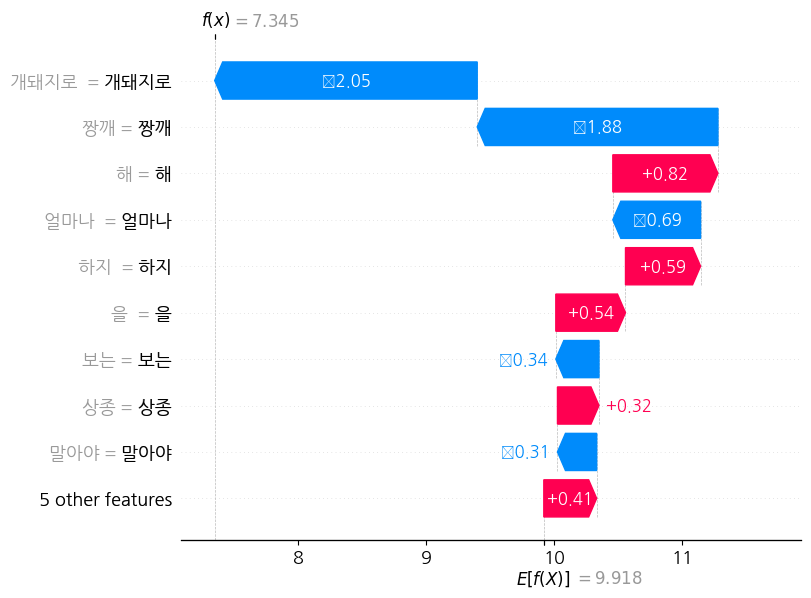

In [8]:
shap.plots.waterfall(shap_values[0])

In [9]:
# force plot을 활용한 첫 번째 예측 설명의 시각화
shap.initjs()
shap.plots.force(shap_values[0])

## 마스킹

In [36]:
samples[5]

'대깨문이 문재인 협박범을 쉴드치네? 역시 대가리가 붕어인듯~'

In [37]:
shap_values[5]

.values =
array([ 0.        , -0.33766222,  0.29422566, -0.22868499,  0.50718166,
        0.02840446,  0.05955225,  0.03414613, -0.21175283, -0.56736583,
       -0.06091577, -0.00749713, -0.41407418,  0.        ])

.base_values =
9.917678833007812

.data =
array(['', '대깨문이 ', '문재인 ', '협박', '범을 ', '쉴드치', '네', '? ', '역시 ', '대가리가 ',
       '붕어', '인듯', '~', ''], dtype='<U5')

In [39]:
shap_values[5].base_values

9.917678833007812

In [51]:
sum([i for i in shap_values[5].values if i < 0]) / len([i for i in shap_values[5].values if i < 0])

-0.2611361358846937

In [ ]:
mask_list = []

shap_values_zip = zip(shap_values[5].values, shap_values[5].data)
for shap_value, feature in shap_values_zip:
    if shap_value < -0.3: # threshold
        print(feature, shap_value)
        mask_list.append(feature.strip())

mask_list

대깨문이  -0.3376622200012207
대가리가  -0.567365825176239
~ -0.414074182510376


['대깨문이', '대가리가', '~']

In [75]:
test_smaple = samples[5]
print(f"원본 문장 : {test_smaple}")

for mask in mask_list:
    # 만약에 mask가 특수문자이면 continue
    if not mask.isalnum():
        continue
    else:
        test_smaple = test_smaple.replace(mask, "[mask]")

print(f"마스킹 문장 : {test_smaple}")

원본 문장 : 대깨문이 문재인 협박범을 쉴드치네? 역시 대가리가 붕어인듯~
마스킹 문장 : [mask] 문재인 협박범을 쉴드치네? 역시 [mask] 붕어인듯~


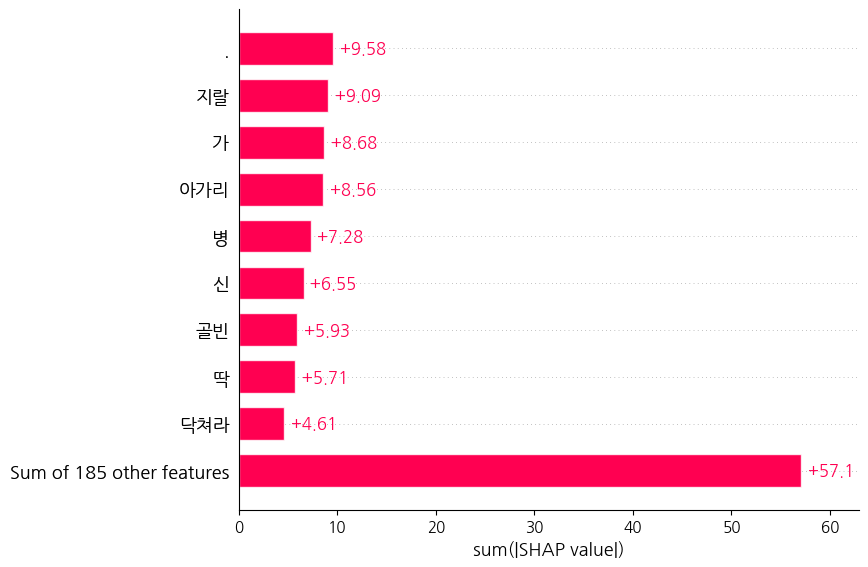

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))

In [ ]:
# test data 전체에 대한 shap value 계산(시간 오래 걸림)
hap_values = explainer(test_data["content"].tolist())